Display scene bitmap and overlays the ground truth trajectories on it.

In [ ]:
import sys
import os
import dill
import argparse

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
from sklearn.model_selection import train_test_split

from kalman_filter import NonlinearKinematicBicycle

nu_path = './devkit/python-sdk/'
sys.path.append(nu_path)
sys.path.append("../../trajectron")
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.utils.splits import create_splits_scenes
from environment import Environment, Scene, Node, GeometricMap, derivative_of

In [2]:
FREQUENCY = 2
dt = 1 / FREQUENCY
data_columns_vehicle = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration', 'heading'], ['x', 'y']])
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_tuples([('heading', '°'), ('heading', 'd°')]))
data_columns_vehicle = data_columns_vehicle.append(pd.MultiIndex.from_product([['velocity', 'acceleration'], ['norm']]))

data_columns_pedestrian = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])

curv_0_2 = 0
curv_0_1 = 0
total = 0

scene_blacklist = [499, 515, 517]

standardization = {
    'PEDESTRIAN': {
        'position': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 2},
            'y': {'mean': 0, 'std': 2}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        }
    },
    'VEHICLE': {
        'position': {
            'x': {'mean': 0, 'std': 80},
            'y': {'mean': 0, 'std': 80}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 15},
            'y': {'mean': 0, 'std': 15},
            'norm': {'mean': 0, 'std': 15}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 4},
            'y': {'mean': 0, 'std': 4},
            'norm': {'mean': 0, 'std': 4}
        },
        'heading': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1},
            '°': {'mean': 0, 'std': np.pi},
            'd°': {'mean': 0, 'std': 1}
        }
    }
}

data_path = "./v1.0"
version = "v1.0-trainval"
output_path = "../processed"
val_split = 0.15

In [3]:
nusc = NuScenes(version=version, dataroot=data_path, verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 21.8 seconds.
Reverse indexing ...
Done reverse indexing in 6.1 seconds.


In [4]:
splits = create_splits_scenes()
train_scenes, val_scenes = train_test_split(splits['train'], test_size=val_split)

ns_scene_names = dict()
ns_scene_names['train'] = splits['train']
ns_scene_names['val'] = val_scenes
ns_scene_names['test'] = splits['val']

# the loop `for data_class in ['train', 'val', 'test']:` in `process_data()`
env = Environment(node_type_list=['VEHICLE', 'PEDESTRIAN'], standardization=standardization)
attention_radius = dict()
attention_radius[(env.NodeType.PEDESTRIAN, env.NodeType.PEDESTRIAN)] = 10.0
attention_radius[(env.NodeType.PEDESTRIAN, env.NodeType.VEHICLE)] = 20.0
attention_radius[(env.NodeType.VEHICLE, env.NodeType.PEDESTRIAN)] = 20.0
attention_radius[(env.NodeType.VEHICLE, env.NodeType.VEHICLE)] = 30.0

env.attention_radius = attention_radius
env.robot_type = env.NodeType.VEHICLE
scenes = []

### Get a scene

In [5]:
# the loop `for ns_scene_name in tqdm(ns_scene_names[data_class]):` in `process_data()`
ns_scene_name = ns_scene_names['test'][6]
ns_scene = nusc.get('scene', nusc.field2token('scene', 'name', ns_scene_name)[0])
scene_id = int(ns_scene['name'].replace('scene-', ''))
if scene_id in scene_blacklist:  # Some scenes have bad localization
    raise Exception("scene ID in backlist")

# the call `scene = process_scene(ns_scene, env, nusc, data_path)` in `process_data()`
# in the body of `process_scene(ns_scene, env, nusc, data_path)`

scene_id = int(ns_scene['name'].replace('scene-', ''))

### Get a sample from a scene

In [6]:
data = pd.DataFrame(columns=['frame_id',
                             'type',
                             'node_id',
                             'robot',
                             'x', 'y', 'z',
                             'length',
                             'width',
                             'height',
                             'heading'])

sample_token = ns_scene['first_sample_token']
sample = nusc.get('sample', sample_token)
frame_id = 0
ego_initx = None
ego_inity = None

while sample['next']:
    annotation_tokens = sample['anns']
    for annotation_token in annotation_tokens:
        annotation = nusc.get('sample_annotation', annotation_token)
        category = annotation['category_name']

        if len(annotation['attribute_tokens']):
            attribute = nusc.get('attribute', annotation['attribute_tokens'][0])['name']
        else:
            continue

        # get pedestrians and vehicles
        if 'pedestrian' in category and not 'stroller' in category and not 'wheelchair' in category:
            our_category = env.NodeType.PEDESTRIAN
        elif 'vehicle' in category and 'bicycle' not in category and 'motorcycle' not in category and 'parked' not in attribute:
            our_category = env.NodeType.VEHICLE
        else:
            continue

        data_point = pd.Series({'frame_id': frame_id,
                                'type': our_category,
                                'node_id': annotation['instance_token'],
                                'robot': False,
                                'x': annotation['translation'][0],
                                'y': annotation['translation'][1],
                                'z': annotation['translation'][2],
                                'length': annotation['size'][0],
                                'width': annotation['size'][1],
                                'height': annotation['size'][2],
                                'heading': Quaternion(annotation['rotation']).yaw_pitch_roll[0]})
        data = data.append(data_point, ignore_index=True)

    # Ego Vehicle
    our_category = env.NodeType.VEHICLE
    sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
    annotation = nusc.get('ego_pose', sample_data['ego_pose_token'])
    data_point = pd.Series({'frame_id': frame_id,
                            'type': our_category,
                            'node_id': 'ego',
                            'robot': True,
                            'x': annotation['translation'][0],
                            'y': annotation['translation'][1],
                            'z': annotation['translation'][2],
                            'length': 4,
                            'width': 1.7,
                            'height': 1.5,
                            'heading': Quaternion(annotation['rotation']).yaw_pitch_roll[0],
                            'orientation': None})
    data = data.append(data_point, ignore_index=True)
    if frame_id == 1:
        ego_initx = annotation['translation'][0]
        ego_inity = annotation['translation'][1]

    sample = nusc.get('sample', sample['next'])
    frame_id += 1

if len(data.index) == 0:
    raise Exception("scene has no samples")

data.sort_values('frame_id', inplace=True)
max_timesteps = data['frame_id'].max()

x_min = np.round(data['x'].min() - 50)
x_max = np.round(data['x'].max() + 50)
y_min = np.round(data['y'].min() - 50)
y_max = np.round(data['y'].max() + 50)

data['x'] = data['x'] - x_min
data['y'] = data['y'] - y_min

scene = Scene(timesteps=max_timesteps + 1, dt=dt, name=str(scene_id), aug_func=None)
scene.ego_initx = ego_initx
scene.ego_inity = ego_inity
scene.x_min = x_min
scene.y_min = y_min
scene.x_max = x_max
scene.y_max = y_max

# Generate Maps
map_name = nusc.get('log', ns_scene['log_token'])['location']
nusc_map = NuScenesMap(dataroot=data_path, map_name=map_name)

type_map = dict()
x_size = x_max - x_min
y_size = y_max - y_min

scene.map_name = map_name
scene.x_size = x_size
scene.y_size = y_size

patch_box = (x_min + 0.5 * (x_max - x_min), y_min + 0.5 * (y_max - y_min), y_size, x_size)
patch_angle = 0  # Default orientation where North is up
canvas_size = (np.round(3 * y_size).astype(int), np.round(3 * x_size).astype(int))
homography = np.array([[3., 0., 0.], [0., 3., 0.], [0., 0., 3.]])
layer_names = ['lane', 'road_segment', 'drivable_area', 'road_divider', 'lane_divider', 'stop_line',
               'ped_crossing', 'stop_line', 'ped_crossing', 'walkway']
scene.patch_box = patch_box
scene.patch_angle = patch_angle
scene.canvas_size = canvas_size
scene.homography = homography
scene.layer_names = layer_names

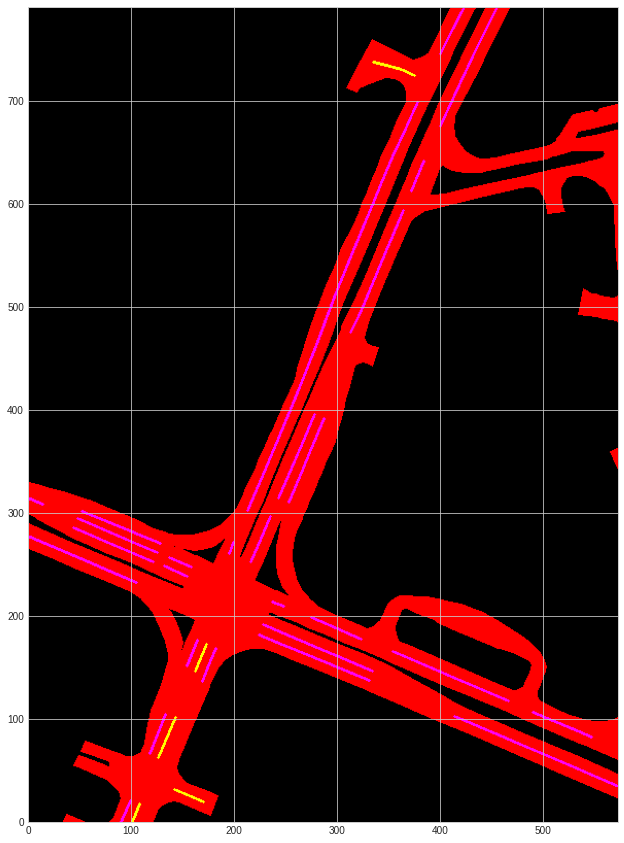

In [10]:
map_mask = (nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size) * 255.0).astype(
    np.uint8)
# has shape (c, y, x)
map_mask = np.swapaxes(map_mask, 1, 2)  # x axis comes first
# now has shape (c, x, y)
# PEDESTRIANS
map_mask_pedestrian = np.stack((map_mask[9], map_mask[8], np.max(map_mask[:3], axis=0)), axis=0)
type_map['PEDESTRIAN'] = GeometricMap(data=map_mask_pedestrian, homography=homography, description=', '.join(layer_names))
# VEHICLES
map_mask_vehicle = np.stack((np.max(map_mask[:3], axis=0), map_mask[3], map_mask[4]), axis=0)
type_map['VEHICLE'] = GeometricMap(data=map_mask_vehicle, homography=homography, description=', '.join(layer_names))

map_mask_plot = np.stack(((np.max(map_mask[:3], axis=0) - (map_mask[3] + 0.5 * map_mask[4]).clip(
    max=255)).clip(min=0).astype(np.uint8), map_mask[8], map_mask[9]), axis=0)
type_map['VISUALIZATION'] = GeometricMap(data=map_mask_plot, homography=homography, description=', '.join(layer_names))


# There's some confusing swapping going on where
# map_mask = np.swapaxes(map_mask, 1, 2) the np image gets transposed before creating GeometricMap, and then
# GeometricMap.as_image() does (np.transpose(GeometricMap.data, (2, 1, 0))).astype(np.uint) to transpose the
# image back.
fig, ax = plt.subplots(figsize=(15,15))
# Axes.imshow() seems to flip the x, y axis
# Axes.imshow() expects (y, x, c)
ax.imshow(map_mask_vehicle.transpose((2,1,0)), origin='lower')

`NuScenesMap.get_map_mask()`

Parameters:

- `patch_box`: of Tuple of (float, float, float, float). Patch box defined as [x_center, y_center, height, width]. If None, this plots the entire map.
- `patch_angle`: float. Patch orientation in degrees. North-facing corresponds to 0.
- `layer_names`: List of str. A list of layer names to be extracted, or None for all non-geometric layers.
- `canvas_size`: Tuple of (int, int). canvas_size: Size of the output mask (h, w). If None, we use the default resolution of 10px/m.

Return list of map mask layers of the specified patch.
Stacked numpy array of size [c x h x w] with c channels and the same width/height as the canvas.

In [8]:
map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size)
print("patch_box", patch_box)
print("canvas_size", canvas_size)
print("x_size, y_size", (x_size, y_size))
print("canvas size is x_size, y_size times 3", (3 * x_size, 3 * y_size))
print("map_mask shape", map_mask.shape)

patch_box (408.5, 1175.0, 264.0, 191.0)
canvas_size (792, 573)
x_size, y_size (191.0, 264.0)
canvas size is x_size, y_size times 3 (573.0, 792.0)
map_mask shape (10, 792, 573)


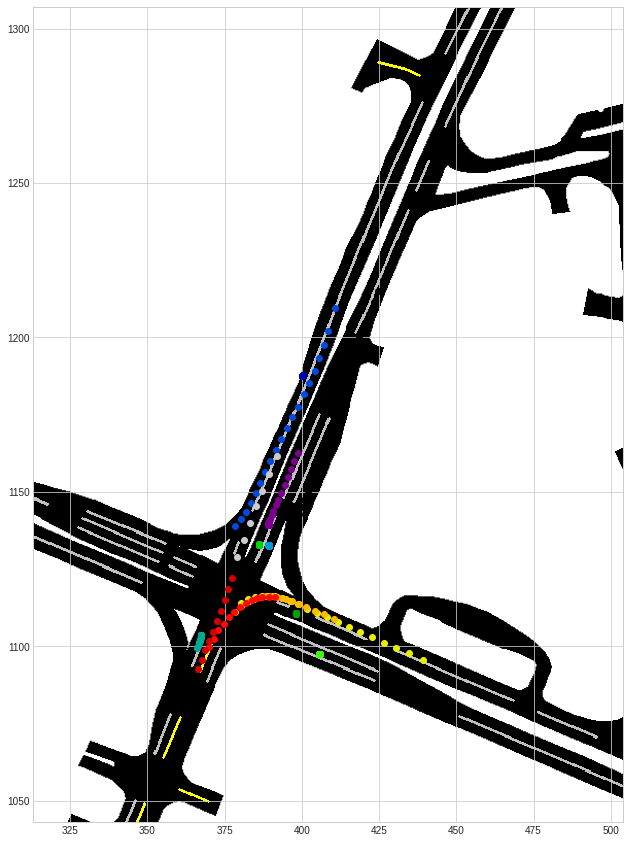

In [9]:
# Check that plotting works
# map_mask has shape (c, y, x)
cp_map_mask = map_mask
# cp_map_mask has shape (y, x, c)
cp_map_mask = cp_map_mask.transpose((1, 2, 0))
road_bitmap = np.max(cp_map_mask[..., :3], axis=2)
road_div_bitmap = cp_map_mask[..., 3]
lane_div_bitmap = cp_map_mask[..., 4]

fig, ax = plt.subplots(figsize=(15,15))
extent = (x_min, x_max, y_min, y_max)
# Axes.imshow() expects (y, x, c)
ax.imshow(road_bitmap, extent=extent, origin='lower')
ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

node_ids = data[data['type'] == 'VEHICLE']['node_id'].unique()

spectral = cm.nipy_spectral(np.linspace(0, 1, len(node_ids)))
for idx, node_id in enumerate(node_ids):
    car_data = data[data['node_id'] == node_id]
    ax.scatter(car_data['x'] + x_min, car_data['y'] + y_min, color=spectral[idx])